# 7장. XGBoost로 외계 행성 찾기

*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/handson-gb/blob/main/Chapter07/Discovering_Exoplanets.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-gb/blob/main/Chapter07/Discovering_Exoplanets.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [2]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.1 MB/s eta 0:00:00
Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
   creating: __MACOSX/
  inflating: __MACOSX/._exoplanets.csv  


In [3]:
# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

## 외계 행성 찾기

### 외계 행성 데이터셋

In [4]:
import pandas as pd
df = pd.read_csv('exoplanets.csv', nrows=400)

In [ ]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [21]:
df['LABEL'].value_counts()

df[df['LABEL'] == 2].index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36],
      dtype='int64')

### 그래프 시각화

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

X = df.iloc[:,1:]
y = df.iloc[:,0] - 1


def light_plot(index):
    y_vals = X.iloc[index]
    x_vals = np.arange(len(y_vals))
    plt.figure(figsize=(15,8))
    plt.xlabel('Number of Observations')
    plt.ylabel('Light Flux')
    plt.title('Light Plot ' + str(index), size=15)
    plt.plot(x_vals, y_vals)
    plt.show()

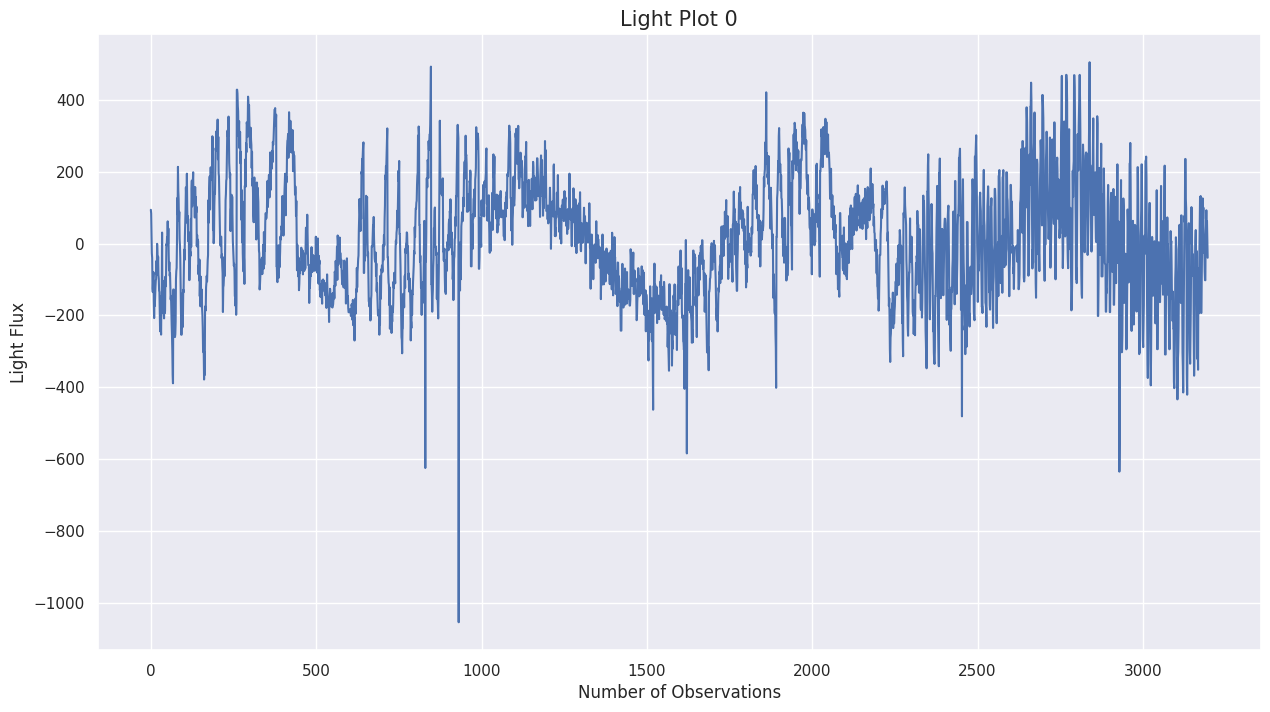

In [115]:
light_plot(0)

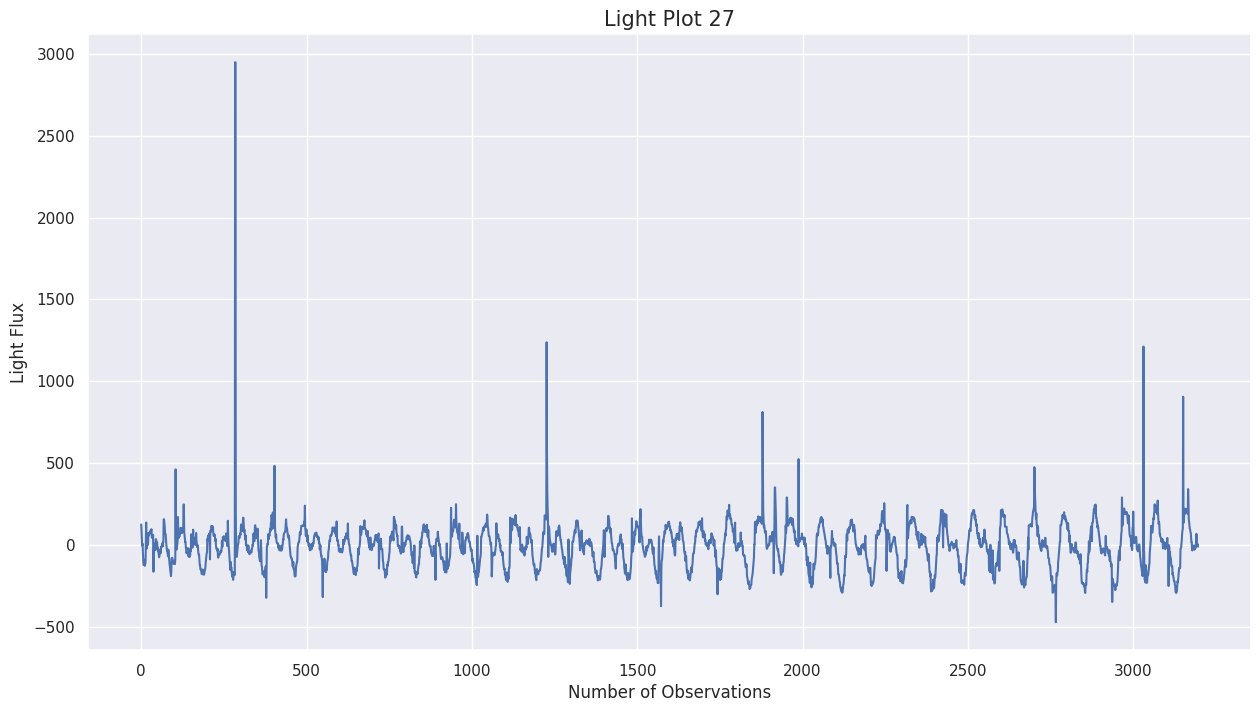

In [47]:
light_plot(27)

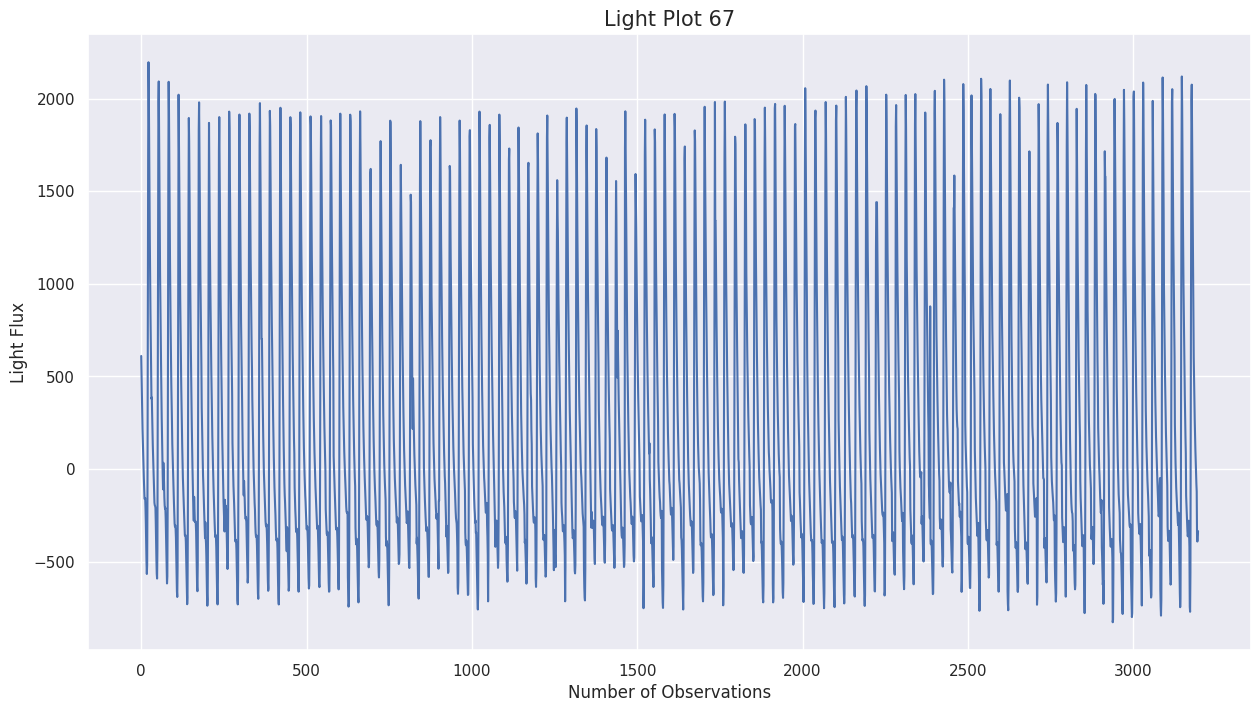

In [120]:
light_plot(67)

# 데이터 전처리

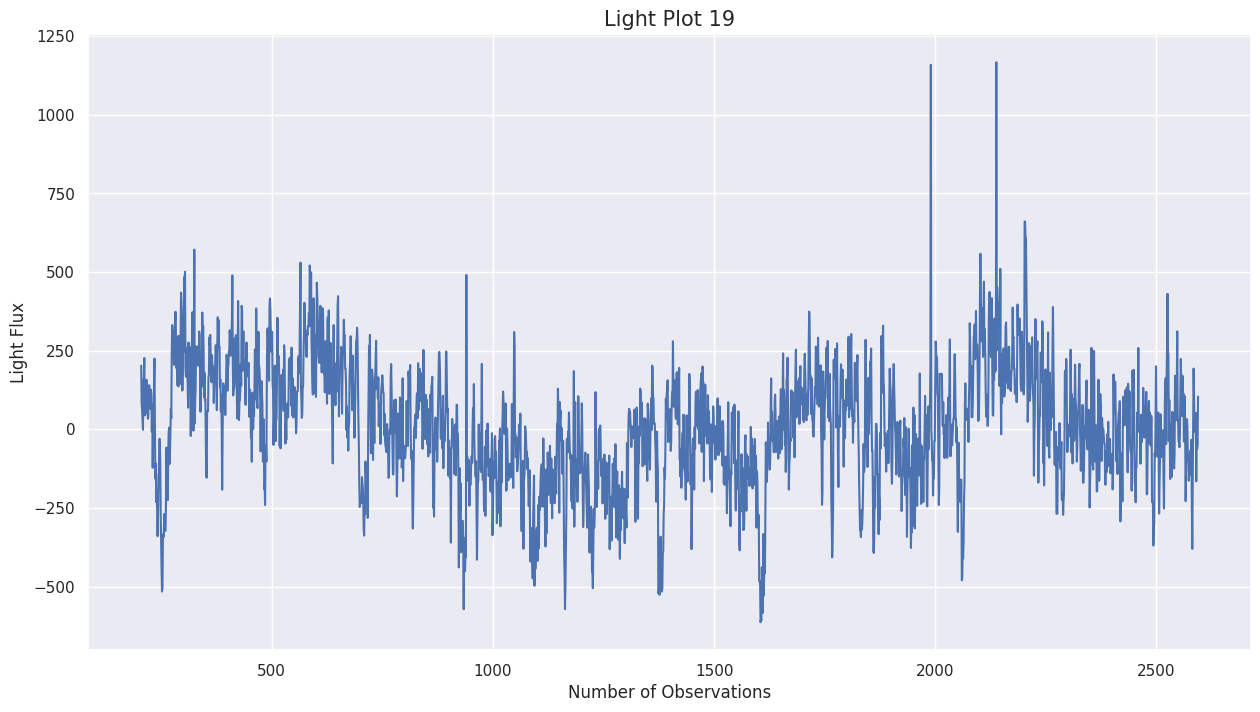

In [21]:
import numpy as np

# Extract flux data as numpy array for processing
flux_data = X.values  # Exclude the "LABEL" column

# Step 1: Find the transit center for each row using the minimum flux (assuming dip represents transit)
transit_centers = np.argmin(flux_data, axis=1)  # Index of minimum flux for each row

# Step 2: Define the data window around the transit center
# Assuming a default window size of one transit duration (e.g., 200 samples before and after)
window_size = 1400  # 총 3000개의 샘플 중 양 옆으로 1400개 선택 (200개 제외) -> 주기의 정수배가 되도록
adjusted_flux_data = []

for i, center in enumerate(transit_centers):
    start = max(0, center - window_size)  # Ensure we don't go below index 0
    end = min(flux_data.shape[1], center + window_size)  # Ensure we don't exceed data length
    windowed_data = flux_data[i, start:end]

    # Pad with NaNs if the window is not symmetrical due to edges
    if len(windowed_data) < 2 * window_size:
        padding = 2 * window_size - len(windowed_data)
        windowed_data = np.pad(windowed_data, (padding // 2, padding - padding // 2), constant_values=np.nan)

    adjusted_flux_data.append(windowed_data)

# Convert back to a DataFrame for visualization
adjusted_flux_df = pd.DataFrame(adjusted_flux_data)



index = 19
# Display the adjusted flux data to the user
y_vals = adjusted_flux_df.iloc[index]
x_vals = np.arange(len(y_vals))
plt.figure(figsize=(15,8))
plt.xlabel('Number of Observations')
plt.ylabel('Light Flux')
plt.title('Light Plot ' + str(index), size=15)
plt.plot(x_vals, y_vals)
plt.show()




### 데이터 준비

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [ ]:
# 누락된 값의 개수를 셉니다.
df.isnull().sum().sum()

0

푸리에 변환을 통한 주파수 분석

[ 0.          0.00031279  0.00062559 ... -0.00093838 -0.00062559
 -0.00031279]
[818846.37          -0.j          16540.91234779+26835.13326036j
  -8008.11584278 +2115.84782006j ...   7526.84038215+12407.26406055j
  -8008.11584278 -2115.84782006j  16540.91234779-26835.13326036j]


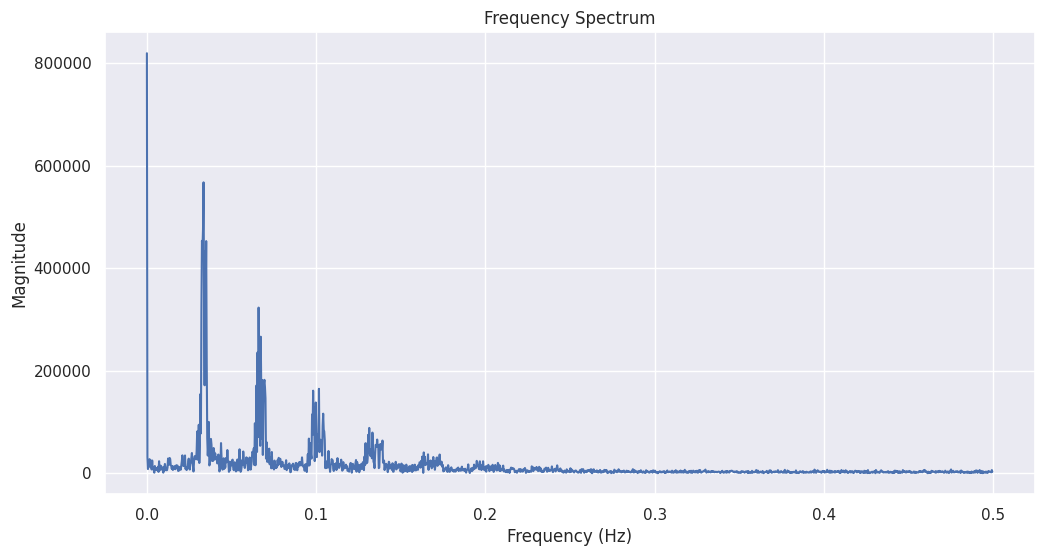

In [117]:
from scipy.fft import fft, fftfreq

# 샘플 하나에 대해 FFT 적용
sample_flux = X.iloc[67,:]  # 첫 번째 샘플 ( 존재 o )
n = len(sample_flux)  # 데이터 포인트 개수
timestep = 1  # 샘플 간 간격 ( 주기적으로 샘플링 되었으므로 1로 통일 )

# 푸리에 변환 수행
freq = fftfreq(n, d=timestep)  # 주파수 값
fft_result = fft(sample_flux.to_numpy())  # FFT 결과

print(freq)
print(fft_result)

# 진폭 계산
magnitude = np.abs(fft_result)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(freq[:n // 2], magnitude[:n // 2])  # 양의 주파수 성분만 시각화
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()



저주파( < 1/8 Hz ) 만 남기고 학습한 경우

<Figure size 1200x600 with 0 Axes>

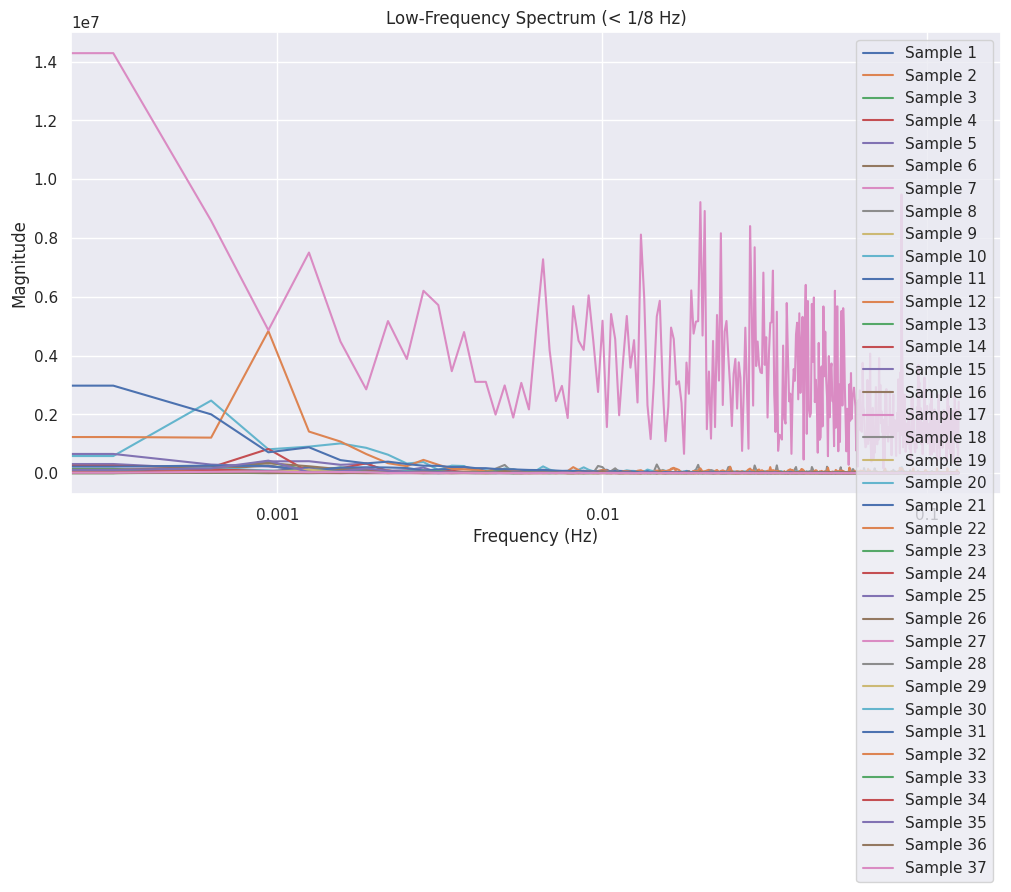

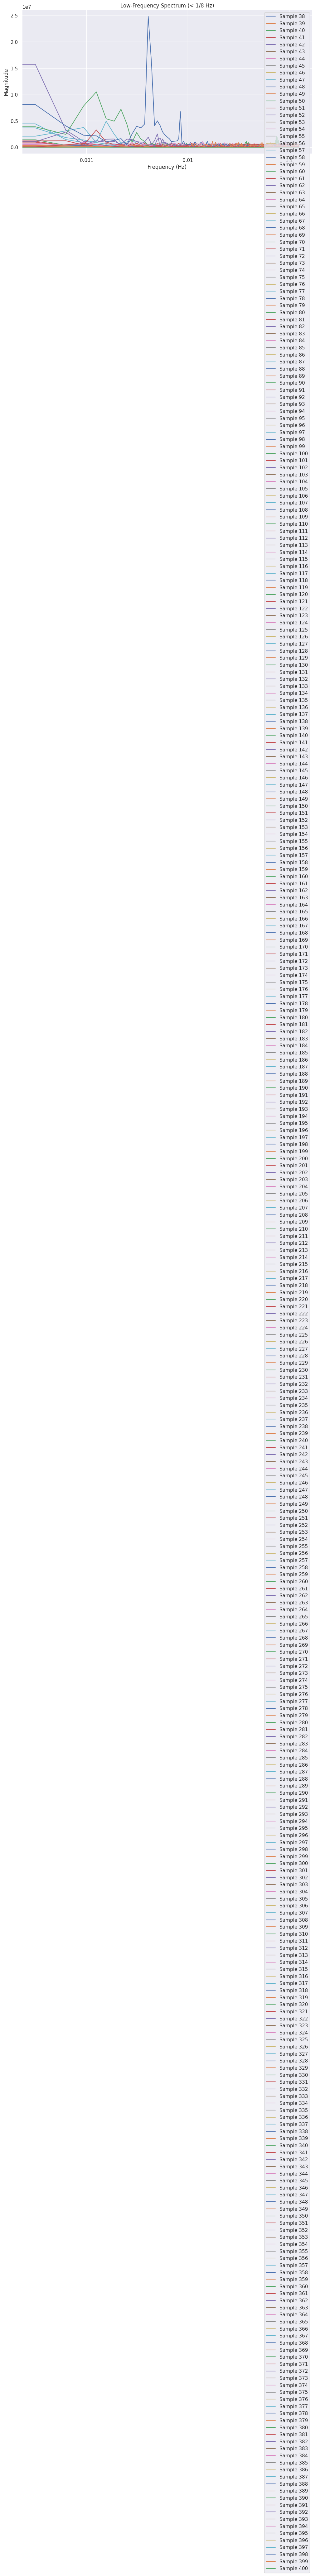

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# FFT 수행 함수 정의
def perform_fft(samples, timestep=1):
    """
    여러 샘플에 대해 FFT를 수행합니다.
    :param samples: 시계열 데이터가 포함된 DataFrame 또는 numpy array (행: 샘플, 열: 시계열 데이터)
    :param timestep: 샘플 간 간격 (1/샘플링 주파수)
    :return: 주파수 값과 모든 샘플의 FFT 결과 (진폭)
    """
    fft_results = []
    freq = None

    for i, sample in enumerate(samples):
        n = len(sample)
        if freq is None:
            freq = fftfreq(n, d=timestep)  # 주파수 값 생성
        fft_result = fft(sample)  # FFT 수행
        magnitude = np.abs(fft_result)  # 진폭 계산
        fft_results.append(magnitude[:n // 2])  # 양의 주파수 성분만 저장

    return freq[:len(freq) // 2], np.array(fft_results)

# 샘플 데이터 준비 (예: X는 DataFrame)
# X = pd.DataFrame(...)  # 실제 시계열 데이터로 대체

def lowPassFilter(freq, fft_results):

  # 진동수 1/8 미만의 저주파만 남기기
  low_freq_threshold = 1 / 8  # 저주파 한계 (Hz)
  low_freq_indices = np.where(freq < low_freq_threshold)[0]  # 해당 주파수 인덱스 찾기

  # 저주파 성분만 유지
  filtered_fft_results = np.zeros_like(fft_results)
  for i in range(len(fft_results)):
      filtered_fft_results[i, low_freq_indices] = fft_results[i, low_freq_indices]
  filtered_fft_results_df = pd.DataFrame(filtered_fft_results, columns=[f'Freq_{i}' for i in range(len(freq))])

  return filtered_fft_results_df


# FFT 수행
timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
freq, fft_results = perform_fft(X.to_numpy(), timestep=timestep)
filtered_fft_results_df = lowPassFilter(freq, fft_results)


# 시각화: 저주파 성분만 포함한 스펙트럼
plt.figure(figsize=(12, 6))


# 외계행성 o
plt.figure(figsize=(12, 6))
for i in range(37):  # 선택된 샘플만 표시
    plt.plot(freq[low_freq_indices], filtered_fft_results[i, low_freq_indices], label=f'Sample {i + 1}')
plt.title("Low-Frequency Spectrum (< 1/8 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xscale("log")  # x축 로그 스케일
plt.xticks([0.001, 0.01, 0.1], labels=["0.001", "0.01", "0.1"])  # x축 눈금 설정
plt.legend(loc='upper right')
plt.show()

# 외계행성 x
plt.figure(figsize=(12, 6))
for i in range(37, 400):  # 선택된 샘플만 표시
    plt.plot(freq[low_freq_indices], filtered_fft_results[i, low_freq_indices], label=f'Sample {i + 1}')
plt.title("Low-Frequency Spectrum (< 1/8 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xscale("log")  # x축 로그 스케일
plt.xticks([0.001, 0.01, 0.1], labels=["0.001", "0.01", "0.1"])  # x축 눈금 설정
plt.legend(loc='upper right')
plt.show()

# 데이터프레임으로 결과 저장 (옵션)
filtered_fft_results_df = pd.DataFrame(filtered_fft_results, columns=[f'Freq_{i}' for i in range(len(freq))])

### 초기 XGBClassifier

In [35]:
# XGBRegressor를 임포트합니다.
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

# train_test_split를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(filtered_fft_results_df, y, random_state=2)

In [36]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier(booster='gbtree')

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))

점수: 0.92


## 오차 행렬 분석하기

### confusion_matrix

In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[88,  0],
       [ 8,  4]])

### classification_report

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        88
           1       1.00      0.33      0.50        12

    accuracy                           0.92       100
   macro avg       0.96      0.67      0.73       100
weighted avg       0.93      0.92      0.90       100



### 다른 측정 방법

####  recall_score

In [41]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.3333333333333333

## 불균형 데이터 리샘플링

### 언더샘플링

#### xgb_clf 함수

In [92]:
def xgb_clf(model, nrows):

    df = pd.read_csv('exoplanets.csv', nrows=nrows) # nrows 개만 fetching
    # 데이터를 X와 y로 나눕니다.

    X = df.iloc[:,1:]
    # FFT 수행
    timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
    freq, fft_results = perform_fft(X.to_numpy(), timestep=timestep)
    filtered_fft_results_df = lowPassFilter(freq, fft_results)

    y = df.iloc[:,0] - 1


    # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
    X_train, X_test, y_train, y_test = train_test_split(filtered_fft_results_df, y, random_state=2)

    # 훈련 세트에서 모델을 훈련합니다.
    model.fit(X_train, y_train)

    # 테스트 세트에 대한 예측을 만듭니다.
    y_pred = model.predict(X_test)

    score = recall_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))

    print(classification_report(y_test, y_pred))

    return score

#### 언더샘플링 테스트

In [93]:
xgb_clf(XGBClassifier(), nrows=800)

[[190   0]
 [  9   1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       190
           1       1.00      0.10      0.18        10

    accuracy                           0.95       200
   macro avg       0.98      0.55      0.58       200
weighted avg       0.96      0.95      0.94       200



0.1

In [94]:
xgb_clf(XGBClassifier(), nrows=200)

[[36  1]
 [ 9  4]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        37
           1       0.80      0.31      0.44        13

    accuracy                           0.80        50
   macro avg       0.80      0.64      0.66        50
weighted avg       0.80      0.80      0.77        50



0.3076923076923077

In [95]:
xgb_clf(XGBClassifier(), nrows=74)

[[7 1]
 [5 6]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.86      0.55      0.67        11

    accuracy                           0.68        19
   macro avg       0.72      0.71      0.68        19
weighted avg       0.74      0.68      0.68        19



0.5454545454545454

### 오버샘플링

In [96]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [97]:
newdf = pd.DataFrame(np.repeat(df_train[df_train['LABEL']==1].values,
                               9,axis=0))
newdf.columns = df_train.columns
df_train_resample = pd.concat([df_train, newdf])

df_train_resample['LABEL'].value_counts()

,count
LABEL,
0.0,275
1.0,250


In [98]:
X_train_resample = df_train_resample.iloc[:,1:]
y_train_resample = df_train_resample.iloc[:,0]

In [99]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier()

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train_resample, y_train_resample)

# 테스트 세트에 대해 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[88  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        88
           1       1.00      0.33      0.50        12

    accuracy                           0.92       100
   macro avg       0.96      0.67      0.73       100
weighted avg       0.93      0.92      0.90       100

0.3333333333333333


## XGBClassifier 튜닝

### 가중치 조정하기

#### replace 메서드

In [122]:

df = pd.read_csv('exoplanets.csv',nrows=400) # nrows 개만 fetching

df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

df['LABEL'].value_counts()

,count
LABEL,
0,363
1,37


#### scale_pos_weight

In [163]:
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]



# FFT 수행
timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
freq, fft_results = perform_fft(X.to_numpy(), timestep=timestep)
filtered_fft_results_df = lowPassFilter(freq, fft_results)


y = df.iloc[:,0]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(filtered_fft_results_df, y, random_state=2)

In [173]:
weight = 10
model = XGBClassifier(scale_pos_weight=weight)

model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)


[[88  0]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        88
           1       1.00      0.33      0.50        12

    accuracy                           0.92       100
   macro avg       0.96      0.67      0.73       100
weighted avg       0.93      0.92      0.90       100

0.3333333333333333


### XGBClassifier 튜닝

#### 기준 모델

In [125]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold, cross_val_score

In [172]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=2)
model = XGBClassifier(scale_pos_weight=10)

# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, filtered_fft_results_df, y, cv=kfold, scoring='recall')

# 재현율을 출력합니다.
print('재현율: ', scores)

# 재현율의 평균을 출력합니다.
print('재현율 평균: ', scores.mean())

재현율:  [0.15789474 0.27777778]
재현율 평균:  0.21783625730994152


#### grid_search

In [174]:
def grid_search(params, random=False, X=filtered_fft_results_df, y=y,
                model=XGBClassifier(scale_pos_weight=10, random_state=2)):

    xgb = model

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_jobs=-1,
                                  random_state=2, scoring='recall')
    else:
        # 그리드 서치 객체를 초기화합니다.
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1, scoring='recall')

    # X_train와 y_train으로 훈련합니다.
    grid.fit(X, y)

    # 최상의 매개변수를 추출합니다.
    best_params = grid.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)

    # 최상의 점수를 추출합니다.
    best_score = grid.best_score_

    # 최상의 점수를 출력합니다.
    print("최상의 점수: {:.5f}".format(best_score))

In [175]:
grid_search(params={'scale_pos_weight':[10, 100, 1000, 10000]})

최상의 매개변수: {'scale_pos_weight': 10000}
최상의 점수: 0.32456


In [161]:
grid_search(params={'n_estimators':[50, 200, 400, 800]})

최상의 매개변수: {'n_estimators': 50}
최상의 점수: 0.21784


In [132]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.2, 0.3]})

최상의 매개변수: {'learning_rate': 0.01}
최상의 점수: 0.27193


In [ ]:
grid_search(params={'max_depth':[1, 2, 4, 8]})

최상의 매개변수: {'max_depth': 2}
최상의 점수: 0.24415


In [133]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9]})

최상의 매개변수: {'subsample': 0.9}
최상의 점수: 0.27193


In [134]:
grid_search(params={'gamma':[0.05, 0.1, 0.5, 1]})

최상의 매개변수: {'gamma': 0.1}
최상의 점수: 0.24561


In [135]:
grid_search(params={'learning_rate':[0.001, 0.01, 0.03],
                    'max_depth':[1, 2], 'gamma':[0.025, 0.05, 0.5]})

최상의 매개변수: {'gamma': 0.025, 'learning_rate': 0.001, 'max_depth': 1}
최상의 점수: 0.78363


In [136]:
grid_search(params={'max_delta_step':[1, 3, 5, 7]})

최상의 매개변수: {'max_delta_step': 1}
최상의 점수: 0.24269


In [137]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bylevel':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bynode':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bytree':[0.3, 0.5, 0.7, 0.9, 1]}, random=True)

최상의 매개변수: {'subsample': 1, 'colsample_bytree': 0.9, 'colsample_bynode': 1, 'colsample_bylevel': 0.7}
최상의 점수: 0.27047


#### 균형잡힌 서브셋

In [138]:
X_short = filtered_fft_results_df.iloc[:74, :]
y_short = y.iloc[:74]

In [139]:
grid_search(params={'max_depth':[1, 2, 3],
                    'colsample_bynode':[0.5, 0.75, 1]},
            X=X_short, y=y_short,
            model=XGBClassifier(random_state=2))

최상의 매개변수: {'colsample_bynode': 0.5, 'max_depth': 3}
최상의 점수: 0.67836


#### 전체 데이터로 튜닝하기

In [148]:
df_all = pd.read_csv('exoplanets.csv')

df_all['LABEL'] = df_all['LABEL'].replace(1, 0)
df_all['LABEL'] = df_all['LABEL'].replace(2, 1)


X_all = df_all.iloc[:,1:]
y_all = df_all.iloc[:,0]

# FFT 수행
timestep = 1  # 샘플 간 시간 간격 (필요시 수정)
freq, fft_results = perform_fft(X_all.to_numpy(), timestep=timestep)



X_all = lowPassFilter(freq, fft_results)


In [ ]:
df_all['LABEL'].value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

In [140]:
weight = int(5050/37)

In [149]:
model = XGBClassifier(scale_pos_weight=weight)

# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, X_all, y_all, cv=kfold, scoring='recall')

# 재현율을 출력합니다.
print('재현율:', scores)

# 재현율의 평균을 출력합니다.
print('재현율 평균:', scores.mean())

재현율: [0.10526316 0.05555556]
재현율 평균: 0.0804093567251462


In [150]:
grid_search(params={'learning_rate':[0.001, 0.01]}, X=X_all, y=y_all,
            model=XGBClassifier(scale_pos_weight=weight))

최상의 매개변수: {'learning_rate': 0.001}
최상의 점수: 0.16228


In [151]:
grid_search(params={'max_depth':[1, 2],'learning_rate':[0.001]}, X=X_all, y=y_all,
            model=XGBClassifier(scale_pos_weight=weight))

최상의 매개변수: {'learning_rate': 0.001, 'max_depth': 1}
최상의 점수: 0.83333


### 결과 통합

In [177]:
def final_model(X, y, model):
    model.fit(X, y)
    y_pred = model.predict(X_all)
    score = recall_score(y_all, y_pred)
    print(score)
    print(confusion_matrix(y_all, y_pred))
    print(classification_report(y_all, y_pred))

#### 74개 샘플

In [178]:
final_model(X_short, y_short,
            XGBClassifier(max_depth=3, colsample_by_node=0.5,
                          random_state=2))

1.0
[[3971 1079]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      5050
           1       0.03      1.00      0.06        37

    accuracy                           0.79      5087
   macro avg       0.52      0.89      0.47      5087
weighted avg       0.99      0.79      0.87      5087



#### 400개 샘플

In [179]:
final_model(filtered_fft_results_df, y,
            XGBClassifier(max_depth=1, colsample_bynode=0.5,
                          scale_pos_weight=weight, random_state=2))

1.0
[[4928  122]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5050
           1       0.23      1.00      0.38        37

    accuracy                           0.98      5087
   macro avg       0.62      0.99      0.68      5087
weighted avg       0.99      0.98      0.98      5087



#### 5,050개 샘플

In [180]:
final_model(X_all, y_all,
            XGBClassifier(max_depth=2, colsample_bynode=0.5,
                          scale_pos_weight=weight, random_state=2))

1.0
[[5050    0]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087

